# Identifying Age Related Conditions
## Logistic Regression

In [35]:
# Util
from datetime import datetime
import os
import math
from functools import reduce
import operator

# Extraction
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

# Transformation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

## Download Files

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_list_files('icr-identify-age-related-conditions')

[greeks.csv, test.csv, sample_submission.csv, train.csv]

In [4]:
# api.competition_download_files('icr-identify-age-related-conditions')

zf = ZipFile('icr-identify-age-related-conditions.zip')
zf.extractall('Data/') #save files in selected folder
zf.close()

## Merge and Transform Data

In [24]:
train_df = pd.read_csv('Data/train.csv')
meta_train_df = pd.read_csv('Data/greeks.csv')

# Merge train data and meta data
train_df = train_df.merge(meta_train_df[['Id','Alpha']], on='Id')
# Create more specific class using meta data (A, B, D, G)
train_df['ClassB'] = train_df.apply(lambda x: int(x['Alpha']=='B'), axis=1)
train_df['ClassD'] = train_df.apply(lambda x: int(x['Alpha']=='D'), axis=1)
train_df['ClassG'] = train_df.apply(lambda x: int(x['Alpha']=='G'), axis=1)
# Convert 'EJ' categorical column to binary
train_df['EJ'] = train_df.apply(lambda x: int(x['EJ'] == 'A'), axis=1)

# Drop categorical 'Alpha' column
train_df = train_df.drop(columns=['Alpha'])

# Fill NaN values with column average
drop_dict = train_df.drop(columns=['Id']).median()
train_df = train_df.fillna(drop_dict)

train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GB,GE,GF,GH,GI,GL,Class,ClassB,ClassD,ClassG
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,1,0,0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,0,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,1,0


In [25]:
stats = {'min':train_df.drop(columns='Id').min(), 
         'max':train_df.drop(columns='Id').max(),
         'median':train_df.drop(columns='Id').median(), 
         'q1':train_df.drop(columns='Id').quantile(0.25), 
         'q3':train_df.drop(columns='Id').quantile(0.75)}

stats_df = pd.DataFrame(stats)
stats_df['iqr'] = stats_df.apply(lambda x: x['q3']-x['q1'], axis=1)
stats_df['min_threshold'] = stats_df.apply(lambda x: x['q1']-1.5*x['iqr'], axis=1)
stats_df['max_threshold'] = stats_df.apply(lambda x: x['q3']+1.5*x['iqr'], axis=1)

stats_df.head()

,min,max,median,q1,q3,iqr,min_threshold,max_threshold
AB,0.081187,6.161666,0.354659,0.252107,0.559763,0.307656,-0.209377,1.021247
AF,192.593280,28688.187660,3120.318960,2197.345480,4361.637390,2164.291910,-1049.092385,7608.075255
AH,85.200147,1910.123198,85.200147,85.200147,113.739540,28.539393,42.391057,156.548630
AM,3.177522,630.518230,20.533110,12.270314,39.139886,26.869572,-28.034044,79.444244
AR,8.138688,178.943634,8.138688,8.138688,8.138688,0.000000,8.138688,8.138688


In [26]:
for f in train_df.drop(columns=['Id','Class','ClassB','ClassD','ClassG']).columns:
    train_df[f'{f}out'] = train_df.apply(lambda x: int(x[f] <= stats_df.loc[f]['min_threshold'] or \
                                                       x[f] >= stats_df.loc[f]['max_threshold']), axis=1)
    train_df[f] = train_df.apply(lambda x: max(stats_df.loc[f]['min_threshold'], x[f]), axis=1)
    train_df[f] = train_df.apply(lambda x: min(stats_df.loc[f]['max_threshold'], x[f]), axis=1)
    
train_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FIout,FLout,FRout,FSout,GBout,GEout,GFout,GHout,GIout,GLout
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,1,0,0,0,0,0,0,0,0,0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0,0,0,0,0,0,0,0,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,0,0,0,0,0,0,0,0,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,0,0,0,0,0,0,0,0,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.053744,3.396778,10.858260,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,8.138688,3.499305,0.053744,8.545512,2.804172,...,0,0,0,0,0,1,0,0,0,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,8.138688,5.979825,0.025882,12.622906,3.777550,...,0,0,0,0,0,1,0,0,0,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,8.138688,8.070549,0.025578,15.408390,1.229900,...,0,0,0,0,0,0,0,0,0,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,0,0,0,0,0,0,0,0,0,0


## Visualize Data

<Figure size 2880x2304 with 0 Axes>

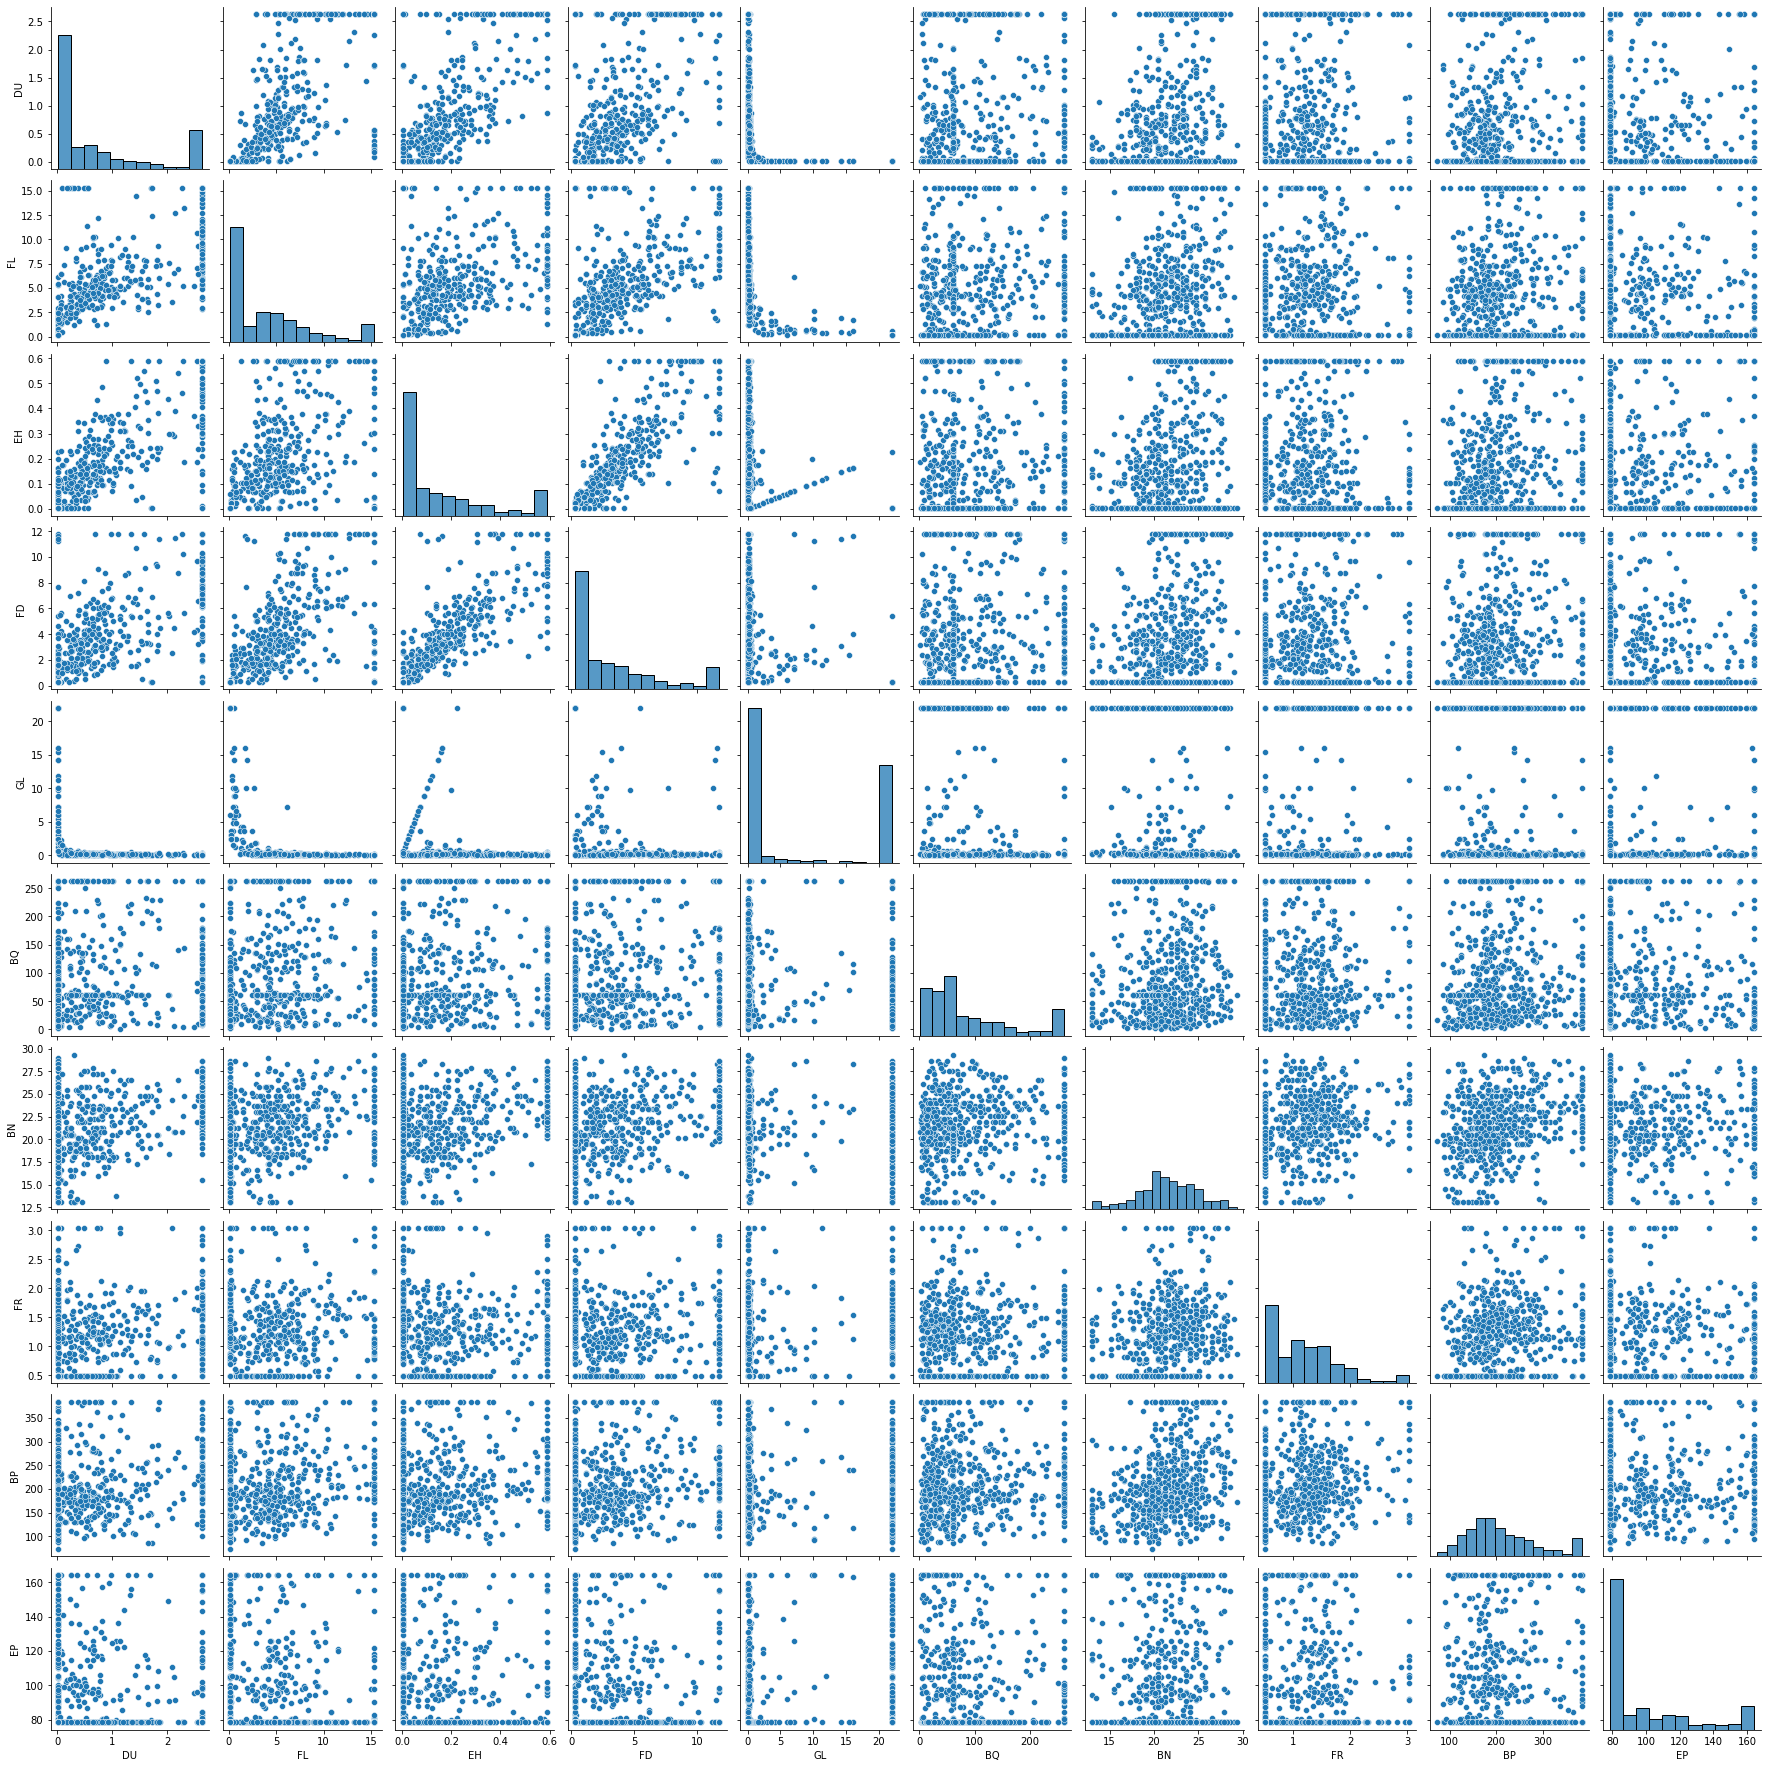

In [38]:
tgt = 'ClassB'

cor_mat = train_df.corr()
cor_mat[tgt] = cor_mat.apply(lambda x: x[tgt]**2, axis=1)

cols = [c for c in cor_mat.columns if 'out' not in c and 'Class' not in c and 'EJ' not in c]
cols_top10 = cor_mat.loc[cols].sort_values(by=tgt, ascending=False).iloc[:10].index

plt.figure(figsize=(40, 32))

sns.pairplot(train_df[cols_top10])
plt.show()

## Train Lasso Logistic Regression Model

### Define loss function

In [29]:
def logloss(y_obs, y_act):
    '''
    inputs: y_obs, array of observed probabilities (between 0 and 1)
            y_act, array of binary values (0 or 1)
    output: loss as negative average of log of corrected probabilities
    '''
    return -np.mean([y*math.log(x) + (1-y)*math.log(1-x) for x,y in list(zip(y_obs, y_act)) if x < 1 and x > 0])

### Tune hyperparameters and train model
For each positive class outcome (B, D, G), train a separate logistic regression model to determine probability of each, and use these predictions to calculate the overall probability of a positive class outcome (the likelihood that we observe B, D, or G).

Because we have upwards of 50 features, some form of feature selection is likely necesssary to avoid overfitting. In this case, I will use Lasso (L1 norm regularization) to shrink the coefficients of each feature (in some cases, all the way to 0). Lasso requires a value $\lambda$ to determine the severity of shrinkage, so I will experiment with a number of different values for this parameter.

In [32]:
targets = ['ClassB','ClassD','ClassG']
params_range = [10**i for i in range(-3,4)]

model_dict = {}
coef_dict = {}

for tgt in targets:
    # Split into train and test with 30% of data reserved for test
    cols = [c for c in train_df.columns if 'Class' not in c and 'Id' not in c]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df[cols], train_df[tgt], test_size=0.3, \
                                                                        random_state=47, stratify=train_df[tgt])

    # Normalize training data (necessary for Lasso regression to work)
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train_norm = min_max_scaler.fit_transform(X_train)
    X_test_norm = min_max_scaler.fit_transform(X_test)

    # Set initial parameters
    best_score = math.inf
    best_lambda = 1
    best_model = None

    # Test different regularization strengths
    for LAMBDA_PARAM in params_range:

        # Set new value for regularization parameter
        print('------------------------------------\nREGULARIZATION PARAMETER = ', \
              LAMBDA_PARAM, '\n------------------------------------')

        # Train logistic regression model with liblinear solver and L1 regularlizer
        model = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=1/LAMBDA_PARAM, random_state=4747)
        model.fit(X_train_norm, y_train)

        # Predict probabilities (0 to 1) from training and test data
        y_pred_train_proba = model.predict_proba(X_train_norm)
        y_pred_test_proba = model.predict_proba(X_test_norm)

        # Calculate entropy (logloss) of predicted probabilities against the actual values
        score = logloss([x[1] for x in y_pred_test_proba], y_test.values)
        print("LOGLOSS: {}\n".format(score))

        # Predict values from training and test data
        y_pred_train = model.predict(X_train_norm)
        y_pred_test = model.predict(X_test_norm)

        # Retrieve confusion matrix for train and test sets
        train_cm = metrics.confusion_matrix(y_train, y_pred_train)
        test_cm = metrics.confusion_matrix(y_test, y_pred_test)

        # TRAIN
        # Retrieve number of true positives/negatives, false positives/negatives from confusion matrix
        train_tn, train_fp, train_fn, train_tp = train_cm.ravel()
        # Calculate precision (correct positive / retrieved positive) and recall (correct positive / relevant [actual] positive)
        if train_tp + train_fp > 0:
            train_precision = train_tp / (train_tp + train_fp)
        else:
            train_precision = np.nan
        if train_tp + train_fn > 0:
            train_recall = train_tp / (train_tp + train_fn)
        else:
            train_recall = np.nan
        # Calculate accuracy (total correct / all)
        train_accuracy = (train_tp + train_tn) / (train_tp + train_tn + train_fp + train_fn)

        print('-- TRAIN --\nPRECISION:\t', train_precision, '\nRECALL:\t\t', train_recall, '\nACCURACY:\t', train_accuracy, '\n')

        # TEST
        # Retrieve number of true positives/negatives, false positives/negatives from confusion matrix
        test_tn, test_fp, test_fn, test_tp = test_cm.ravel()
        # Calculate precision (correct positive / retrieved positive) and recall (correct positive / relevant [actual] positive)
        if test_tp + test_fp > 0:
            test_precision = test_tp / (test_tp + test_fp)
        else:
            test_precision = np.nan
        if test_tp + test_fn > 0:
            test_recall = test_tp / (test_tp + test_fn)
        else:
            test_recall = np.nan
        # Calculate accuracy (total correct / all)
        test_accuracy = (test_tp + test_tn) / (test_tp + test_tn + test_fp + test_fn)

        print('-- TEST --\nPRECISION:\t', test_precision, '\nRECALL:\t\t', test_recall, '\nACCURACY:\t', test_accuracy, '\n')

        # Update best_score and best_lambda if logloss is lower than previously seen
        if score < best_score:
            best_score = score
            best_lambda = LAMBDA_PARAM
            best_model = model

    # Print best value of lambda
    print('\n------------------------------------\nBEST REGULARIZATION PARAMETER = ', best_lambda)

    # Identify the most important (heaviest weighted) features in the model
    d = dict(zip(X_train.columns, best_model.coef_[0]))
    d = dict(sorted(d.items(), reverse=True, key=lambda item: abs(item[1])))

    # Save the top model
    model_dict[tgt] = best_model
    
    # Save coefficients of top model
    coef_dict[tgt] = d

    print('TOP FEATURES:\t', list(d.keys())[:10])
    
feature_df = pd.DataFrame(coef_dict).sort_index()
feature_df.to_csv('Features/lasso_outlier_dummy_features.csv', index=None)

------------------------------------
REGULARIZATION PARAMETER =  0.001 
------------------------------------
LOGLOSS: 1.2157217964643867

-- TRAIN --
PRECISION:	 1.0 
RECALL:		 1.0 
ACCURACY:	 1.0 

-- TEST --
PRECISION:	 0.6428571428571429 
RECALL:		 0.5 
ACCURACY:	 0.9247311827956989 

------------------------------------
REGULARIZATION PARAMETER =  0.01 
------------------------------------
LOGLOSS: 0.6581463547086103

-- TRAIN --
PRECISION:	 1.0 
RECALL:		 1.0 
ACCURACY:	 1.0 

-- TEST --
PRECISION:	 0.65 
RECALL:		 0.7222222222222222 
ACCURACY:	 0.9354838709677419 

------------------------------------
REGULARIZATION PARAMETER =  0.1 
------------------------------------
LOGLOSS: 0.2990930873544294

-- TRAIN --
PRECISION:	 1.0 
RECALL:		 1.0 
ACCURACY:	 1.0 

-- TEST --
PRECISION:	 0.6842105263157895 
RECALL:		 0.7222222222222222 
ACCURACY:	 0.9408602150537635 

------------------------------------
REGULARIZATION PARAMETER =  1 
------------------------------------
LOGLOSS: 0.1156

In [31]:
# Split into train and test with 30% of data reserved for test
cols = [c for c in train_df.columns if 'Class' not in c and 'Id' not in c]
X_pred = train_df[cols].copy()
y_pred = train_df[targets].copy()

for tgt in ['ClassB', 'ClassD', 'ClassG']:
    
    # Normalize training data (necessary for Lasso regression to work)
    min_max_scaler = preprocessing.MinMaxScaler()
    X_pred_norm = min_max_scaler.fit_transform(X_pred)

    # Predict probabilities (0 to 1) from training and test data
    y_pred_proba = model_dict[tgt].predict_proba(X_pred_norm)

    y_pred[f'{tgt}_pred'] = [x[1] for x in y_pred_proba]
    
y_pred['Class'] = y_pred.apply(lambda x: max([x[tgt] for tgt in targets]), axis=1)
y_pred['Class_pred'] = y_pred.apply(lambda x: 1 - reduce(operator.mul, [1-x[f'{tgt}_pred'] for tgt in targets]), axis=1)

# Calculate entropy (logloss) of predicted probabilities against the actual values
score = logloss(y_pred['Class_pred'].values, y_pred['Class'].values)
print("LOGLOSS: {}\n".format(score))

cm = metrics.confusion_matrix(y_pred['Class'], [int(y>0.5) for y in y_pred['Class_pred']])

# TRAIN
# Retrieve number of true positives/negatives, false positives/negatives from confusion matrix
tn, fp, fn, tp = cm.ravel()
# Calculate precision (correct positive / retrieved positive) and recall (correct positive / relevant [actual] positive)
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = np.nan
if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = np.nan
# Calculate accuracy (total correct / all)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print('\nPRECISION:\t', precision, '\nRECALL:\t\t', recall, '\nACCURACY:\t', accuracy, '\n')
        
y_pred

LOGLOSS: 0.1491528607581533


PRECISION:	 0.9222222222222223 
RECALL:		 0.7685185185185185 
ACCURACY:	 0.9481361426256077 



,ClassB,ClassD,ClassG,ClassB_pred,ClassD_pred,ClassG_pred,Class,Class_pred
0,1,0,0,0.820105,0.027631,3.969291e-06,1.0,0.825076
1,0,0,0,0.003334,0.022372,4.078461e-10,0.0,0.025631
2,0,0,0,0.073761,0.014963,3.968996e-07,0.0,0.087620
3,0,0,0,0.066996,0.013999,1.368255e-08,0.0,0.080057
4,0,1,0,0.014903,0.661538,1.665108e-10,1.0,0.666583
...,...,...,...,...,...,...,...,...
612,0,0,0,0.018453,0.014965,9.241440e-07,0.0,0.033143
613,0,0,0,0.023493,0.014233,5.404477e-11,0.0,0.037391
614,0,0,0,0.000742,0.012587,1.695266e-06,0.0,0.013322
615,0,0,0,0.025535,0.014172,1.697985e-04,0.0,0.039508


In [37]:
test_df = pd.read_csv('Data/test.csv')
# Convert 'EJ' categorical column to binary
test_df['EJ'] = test_df.apply(lambda x: int(x['EJ'] == 'A'), axis=1)

# Fill NaN values with column average
drop_dict = test_df.drop(columns=['Id']).median()
test_df = test_df.fillna(drop_dict)

for f in test_df.drop(columns=['Id']).columns:
    test_df[f'{f}out'] = test_df.apply(lambda x: int(x[f] <= stats_df.loc[f]['min_threshold'] or \
                                                       x[f] >= stats_df.loc[f]['max_threshold']), axis=1)
    test_df[f] = test_df.apply(lambda x: max(stats_df.loc[f]['min_threshold'], x[f]), axis=1)
    test_df[f] = test_df.apply(lambda x: min(stats_df.loc[f]['max_threshold'], x[f]), axis=1)

for tgt in targets:
    # Normalize training data (necessary for Lasso regression to work)
    cols = [c for c in train_df.columns if 'Class' not in c and 'Id' not in c]
    min_max_scaler = preprocessing.MinMaxScaler()
    X_norm = min_max_scaler.fit_transform(test_df[cols])
    
    # Predict probabilities (0 to 1) from training and test data
    y_proba = model_dict[tgt].predict_proba(X_norm)
    
    test_df[f'{tgt}_pred'] = [x[1] for x in y_proba]
    
# Predict the two binary classes
test_df['class_0'] = test_df.apply(lambda x: reduce(operator.mul, [1-x[f'{tgt}_pred'] for tgt in targets]), axis=1)
test_df['class_1'] = 1 - test_df['class_0']

predictions_final = test_df[['Id','class_0','class_1']].head()

if not os.path.exists('Predictions/logreg-outdum'):
    os.makedirs('Predictions/logreg-outdum/')
predictions_final.to_csv('Predictions/logreg-outdum/submission.csv', index=None)

predictions_final.head()

,Id,class_0,class_1
0,00eed32682bb,0.350105,0.649895
1,010ebe33f668,0.350105,0.649895
2,02fa521e1838,0.350105,0.649895
3,040e15f562a2,0.350105,0.649895
4,046e85c7cc7f,0.350105,0.649895
